In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetLarge,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (331,331,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(331, 331))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 331, 331, 3)

In [5]:
# Creating base_model
image_shape = (331, 331, 3)                                                                                                                                                                                                                                                                                            
base_model = NASNetLarge(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 4032)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.1min


[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 2.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 2.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 2.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 2.3min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505718, total= 2.3min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 2.3min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.8min


[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 2.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 2.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.7min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 2.7min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505718, total= 2.7min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 2.7min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505718, total= 2.7min
[CV] C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.8min


[CV] ............... C=0.01, gamma=0.01, score=0.785260, total= 1.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.815522, total= 1.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.819338, total= 1.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.837150, total= 1.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.820611, total= 1.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 2.4min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.650572, total= 2.4min
[CV] .............. C=0.01, gamma=0.001, score=0.652672, total= 2.4min
[CV] C

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.9min


[CV] ................ C=0.01, gamma=0.1, score=0.773537, total= 2.8min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total= 2.8min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.770992, total= 2.9min
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.767176, total= 2.8min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 11.9min


[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 2.5min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 2.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 2.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505718, total= 2.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 2.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 2.4min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 2.4min
[CV] C

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 14.9min


[CV] ............... C=0.1, gamma=1e-06, score=0.505718, total= 2.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505718, total= 2.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 2.8min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 15.6min


[CV] .............. C=0.1, gamma=0.0001, score=0.709924, total= 2.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.683206, total= 2.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.688295, total= 2.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.879135, total= 1.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.827192, total= 1.5min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.851145, total= 1.5min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.870229, total= 1.6min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 20.0min


[CV] ................. C=0.1, gamma=1.0, score=0.522901, total= 2.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.524173, total= 2.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505718, total= 2.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.7min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 2.7min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total= 2.7min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 22.0min


[CV] ............... C=1.0, gamma=1e-06, score=0.505089, total= 2.3min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.889313, total= 1.1min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.945293, total=  48.1s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.874206, total= 1.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.893130, total= 1.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.894402, total= 1.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.910941, total= 1.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 24.1min


[CV] ................. C=1.0, gamma=0.1, score=0.919949, total= 1.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.931298, total= 1.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.921120, total= 1.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.942748, total= 1.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.905852, total= 1.3min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.688295, total= 2.7min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.694656, total= 2.7min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 28.4min


[CV] ................ C=1.0, gamma=10.0, score=0.567430, total= 2.8min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 2.3min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505718, total= 2.8min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.566158, total= 2.8min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.578880, total= 2.8min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 2.8min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 2.3min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 30.1min


[CV] .............. C=10.0, gamma=1e-06, score=0.689567, total= 2.8min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.924936, total=  53.8s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.912214, total=  53.7s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.804320, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.820611, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.893130, total= 1.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.912214, total= 1.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 34.5min


[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total= 2.3min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total= 2.3min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.753181, total= 2.7min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.776081, total= 2.7min
[CV] ................ C=10.0, gamma=1.0, score=0.764631, total= 2.7min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.750636, total= 2.7min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.556544, total= 2.7min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 36.3min


[CV] ............. C=100.0, gamma=0.001, score=0.951654, total=  44.2s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=0.001, score=0.963104, total=  44.1s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.926302, total=  54.4s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.878018, total= 1.1min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.923664, total=  53.6s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.936387, total=  54.2s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.894402, total= 1.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 39.7min


[CV] ............ C=1000.0, gamma=1e-07, score=0.804320, total= 1.6min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.848601, total= 1.6min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.820611, total= 1.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.826972, total= 1.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.750636, total= 2.3min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.572519, total= 2.3min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.687421, total= 2.3min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 42.5min remaining:  2.4min


[CV] ............. C=1000.0, gamma=0.01, score=0.937659, total=  42.6s
[CV] .............. C=1000.0, gamma=0.1, score=0.931385, total= 1.6min
[CV] .............. C=1000.0, gamma=0.1, score=0.940204, total= 1.5min
[CV] .............. C=1000.0, gamma=0.1, score=0.951654, total= 1.6min
[CV] .............. C=1000.0, gamma=0.1, score=0.916031, total= 1.6min
[CV] .............. C=1000.0, gamma=0.1, score=0.928753, total= 1.7min
[CV] .............. C=1000.0, gamma=1.0, score=0.753181, total= 1.8min
[CV] .............. C=1000.0, gamma=1.0, score=0.764631, total= 1.8min
[CV] .............. C=1000.0, gamma=1.0, score=0.770013, total= 1.9min
[CV] ............. C=1000.0, gamma=10.0, score=0.556544, total= 1.8min
[CV] .............. C=1000.0, gamma=1.0, score=0.750636, total= 1.8min
[CV] ............. C=1000.0, gamma=10.0, score=0.568702, total= 1.7min
[CV] ............. C=1000.0, gamma=10.0, score=0.571247, total= 1.8min
[CV] .............. C=1000.0, gamma=1.0, score=0.776081, total= 1.9min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 45.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([127.97668881, 117.3350914 , 117.65908589, 130.92917652,
        109.37074142, 113.23813229,  86.21679168, 130.22887702,
        135.01151276, 128.37056746, 115.58684916, 114.7634604 ,
        134.81376953, 135.49593163, 121.22919855,  77.28296356,
         56.44131222,  76.90556345, 131.37388506, 127.51067314,
        118.84462333, 110.32072473, 112.8455215 , 117.38934474,
         90.36413841,  61.63874836,  37.04722853,  63.62342157,
        128.70975375, 125.09498692, 125.15928745, 111.62579722,
        118.64829226,  85.0923759 ,  56.16846771,  41.43762178,
         34.71583405,  96.81941218, 128.65823393, 130.99843936,
        112.14284053, 121.11708374,  75.56129699,  54.24424801,
         44.22660251,  34.32766309,  31.86198211,  98.02860045,
        129.23164454, 127.82794709, 110.66395864,  81.86108885,
         55.95288587,  39.10800147,  29.6326283 ,  32.29088273,
         34.25521135,  81.86587081,  91.82166672,  89.34098659]),
 'mean_score_time': a

In [11]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-06},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-05},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.65327, std: 0.00737, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.81557, std: 0.01688, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.77283, std: 0.00375, params: {'C': 0.01, 'gamma': 0.1},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-06},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-05},
 mean: 0.69244, std: 0.01009, params: {'C': 0.1, 'gamma': 0.0001},
 mea

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.01} - score: 0.9491


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


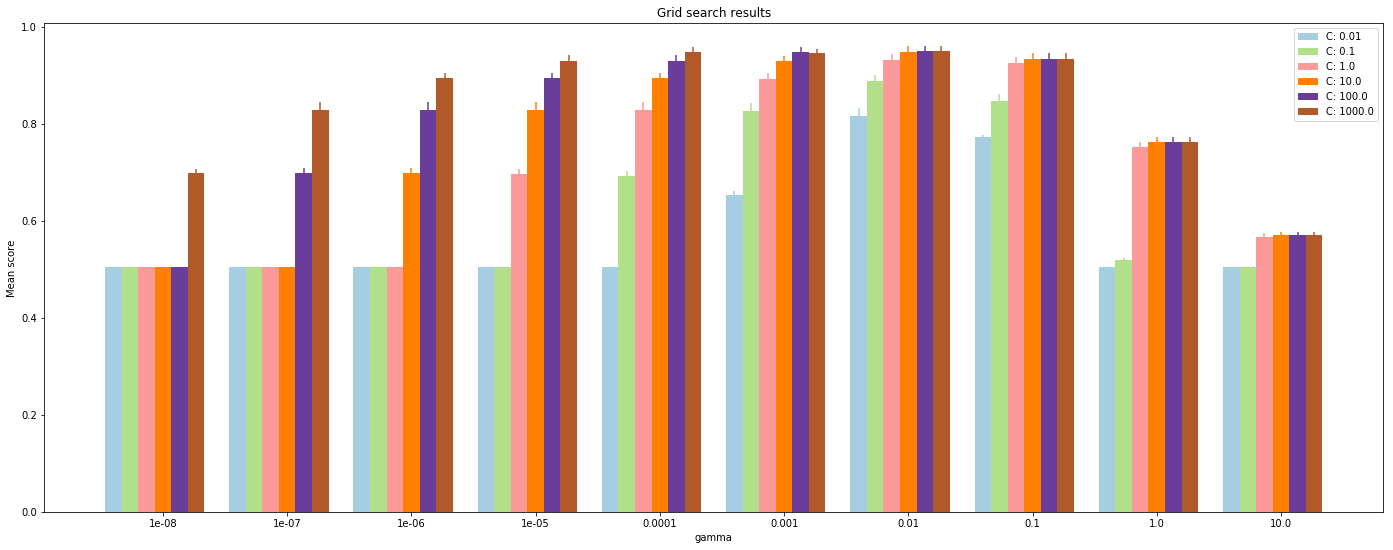

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()